# pandas-ml-qunat - The Pandas Machine Leraning and Quant Finance Library

[![Python 3.7](https://img.shields.io/badge/python-3.7-blue.svg)](https://www.python.org/downloads/release/python-360/)

[![Actions Status](https://github.com/KIC/pandas-ml-qunat/workflows/Python%20package/badge.svg)](https://github.com/KIC/pandas-ml-qunat/actions?query=branch%3Amaster)


This is the root repository of the follwoing 3 core components:

* [pandas-ml-common](../pandas-ml-common/Readme.md) - a more general utilities and monkey patched pandas objects provider
* [pandas-ml-utils](../pandas-ml-utils/Readme.md) - apply statistical or ml models directly to data frames
* [pandas-ml-quant](../pandas-ml-quant/Readme.md) - provides technical analysis inidcators, plots, loss functions, etc.
* [pandas-ml-quant-data-provider](../pandas-ml-quant-data-provider/Readme.md) - a collection of data providers such as yahoo finance, FRED, investing.com and cryptocompare

You will also find an integration test module which is used mainly for testing but may also serve as a source of documentation.

Last but not least there are some notebooks which I use for my experiments feel free to use them as well. 

## Installation
Currenty all 3 libraries are very much entangled. This dependency will weaken up as we reach stablity. Never the less it is possible to only use `pandas-ml-utils` together with `pandas-ml-common`.

```bash
pip install pandas-ml-common pandas-ml-utils pandas-ml-quant pandas-ml-quant-data-provider
```

## Demonstration of all 4 libraries used together
### First import needed objects

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
import sys
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from pandas_ml_utils.ml.summary import ClassificationSummary
from pandas_ml_utils import FeaturesAndLabels, Model, SkModel
from pandas_ml_quant import pd, np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Next fetch some stock data and plot it

Note that:
1. all indicators and charting functionalities are behind the **q**and property attached to all pandas objects
1. the **m**achine**l**earning proptery provides access to (raw) data as it is useful/needed by statistical and ml models
1. all model relevant functionalities are behind the **model** property


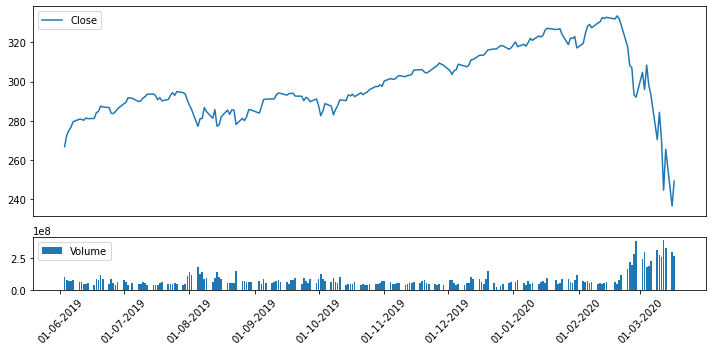

In [12]:
import pandas_ml_quant_data_provider
df = pd.fetch_yahoo("SPY").loc[:'2020-03-17']

# NOTE the access to the q_uant property
df[-200:].ta.plot(figsize=(10, 5))()

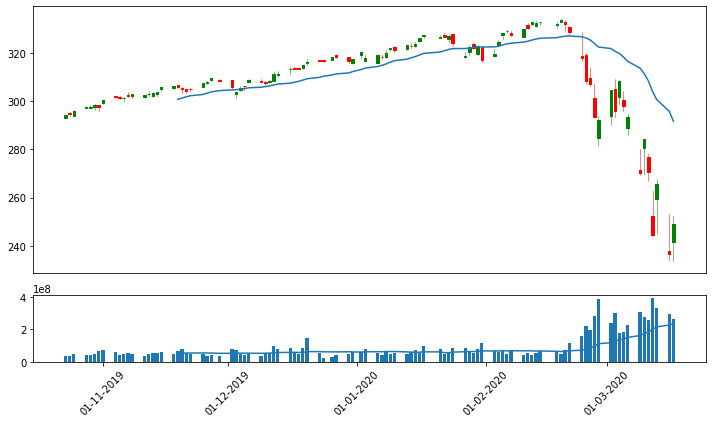

In [13]:
plt = df[-100:].ta.plot(figsize=(10, 6))
plt.candlestick()
plt.line(df[-100:]["Close"].ta.sma(period=20))
plt.bar("Volume")
plt.line(df[-100:]["Volume"].ta.sma(period=20), panel=1)

### Now think of a predictive model
Lets say we want to predict in which quantile of a bolliner bands indicator the price in the future will be:
* 0 means below lower band
* 1 means in the middle band
* 2 means above the upper band


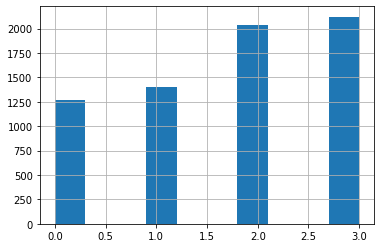

In [14]:
# NOTE all technical analysis starts with the "ta_" prefix
df["Close"].ta.future_bband_quantile(5, 5).hist()

And we want to predict this event based on a set of indicators like the RSI (Relative Strength Index) and such.

So we can build up a features and labels definition like so:

In [15]:
fnl = FeaturesAndLabels(
    features=[
        lambda df: df["Close"].ta.macd(),
        lambda df: df["Close"].ta.apo(),
        lambda df: df["Close"].ta.rsi(),
        lambda df: df["Close"].ta.roc(),
        lambda df: df["Close"].ta.trix(),
        lambda df: df["Close"].ta.ppo(),
        lambda df: df["Close"].ta.returns().ta.zscore() / 4.,
        lambda df: df["Close"].ta.sinusoidal_week_day(),
        lambda df: df["Close"].ta.sinusoidal_week(),
        lambda df: df["Close"].ta.up_down_volatility_ratio(),
        lambda df: df.ta.adx(), 
        lambda df: df.ta.atr(),
        lambda df: df.ta.tr(),
        lambda df: df.ta.williams_R(),
        lambda df: df.ta.ultimate_osc(),
        lambda df: df.ta.bop(),
        lambda df: df.ta.cci(),
    ],
    labels=[
        lambda df: df["Close"].ta.future_bband_quantile(5, 5)
    ],
    targets=[
        lambda df: df["Close"].ta.bbands(5, stddev=2.0)
    ]
)

# NOTE the df.ml property provides access to (raw) data as it is useful/needed by statistical models
(features, req_samples), labels, targets, weights, gross_loss = df._.extract(fnl)
display(labels.tail())
display(targets.tail())
features.describe()

,Close_quantile
Date,
2020-03-04,0.0
2020-03-05,0.0
2020-03-06,0.0
2020-03-09,0.0
2020-03-10,0.0


,lower,mean,quantile,upper,z
Date,,,,,
2020-03-04,284.370301,298.902,2.0,313.433699,1.311340
2020-03-05,286.628612,299.878,1.0,313.127388,-0.256314
2020-03-06,287.534917,300.114,1.0,312.693083,-1.091336
2020-03-09,265.192640,293.240,1.0,321.287360,-1.632239
2020-03-10,262.080199,290.910,1.0,319.739801,-0.455778


,"macd_12,26,9","signal_12,26,9","histogram_12,26,9","Close_apo_12,26,0",Close_rsi_12,Close_roc_12,Close_trix_30,"Close_ppo_12,26,1",Close_return_z_20,dow,...,-DM,+DI,-DI,ADX,atr_14,true_range,williams_R_14,"ultimate_osc_7,14,28",bop,cci_14
count,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6.696000e+03,...,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000
mean,0.002469,0.002483,-0.000013,1.002586,0.550774,0.004898,0.036966,0.002469,-0.001885,1.813273e-01,...,0.003464,0.238951,0.231718,0.231247,0.014070,0.014121,0.377446,0.546918,0.035904,0.240861
std,0.010856,0.010182,0.003328,0.015172,0.123065,0.033913,0.104872,0.010856,0.061551,6.519733e-01,...,0.002748,0.071981,0.074225,0.082955,0.007753,0.010767,0.301298,0.101995,0.535471,1.052087
min,-0.074454,-0.067686,-0.026182,0.891743,0.144136,-0.255829,-0.558644,-0.074454,-0.243257,-8.660254e-01,...,0.000384,0.045156,0.042934,0.076750,0.003787,0.001415,0.000000,0.213705,-1.000000,-3.527936
25%,-0.002271,-0.001857,-0.001821,0.995343,0.463242,-0.011348,-0.004624,-0.002271,-0.039967,0.000000e+00,...,0.001727,0.185376,0.177930,0.169514,0.008949,0.007431,0.105132,0.475047,-0.419028,-0.565185
50%,0.004365,0.004194,-0.000018,1.004728,0.558969,0.007937,0.053193,0.004365,-0.001936,1.224647e-16,...,0.002674,0.239408,0.222886,0.217286,0.011997,0.011417,0.306610,0.550647,0.052632,0.465331
75%,0.009249,0.008944,0.001737,1.011817,0.641630,0.024079,0.100390,0.009249,0.038231,8.660254e-01,...,0.004235,0.290214,0.277708,0.278593,0.017149,0.017481,0.627529,0.620731,0.495074,1.055187
max,0.030250,0.026988,0.018455,1.059508,0.882796,0.204541,0.248466,0.030250,0.209825,8.660254e-01,...,0.027589,0.498748,0.683098,0.588639,0.073400,0.145105,1.000000,0.848189,1.000000,3.219351


Since we have no idea which features are actually "good" to predict the label, we want to do some feature analysis fist.


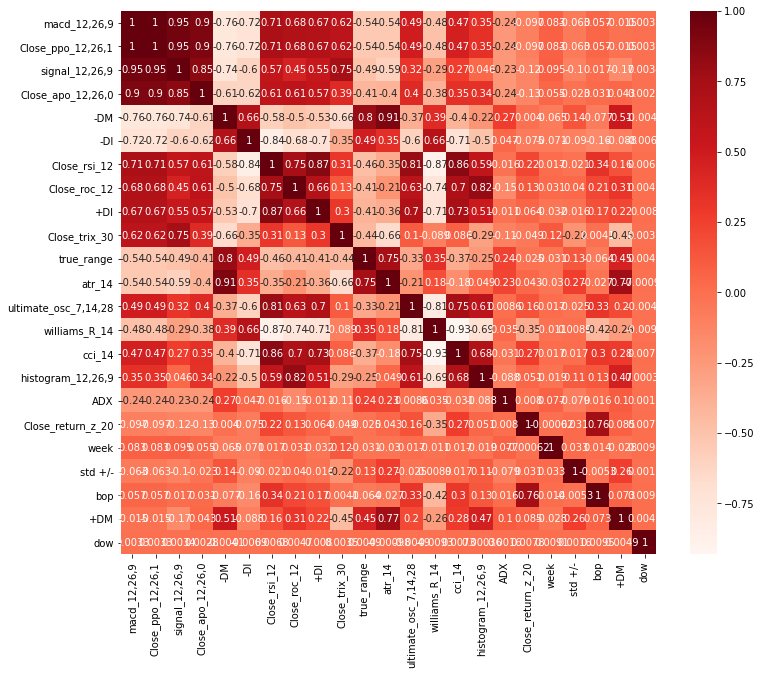

              macd_12,26,9  Close_ppo_12,26,1  signal_12,26,9  \
macd_12,26,9           1.0                1.0        0.951947   

              Close_apo_12,26,0       -DM       -DI  Close_rsi_12  \
macd_12,26,9            0.90493 -0.758002 -0.715884      0.713533   

              Close_roc_12       +DI  Close_trix_30  ...  williams_R_14  \
macd_12,26,9      0.679079  0.672968       0.618233  ...      -0.482839   

                cci_14  histogram_12,26,9       ADX  Close_return_z_20  \
macd_12,26,9  0.465266            0.34944 -0.243392          -0.096866   

                  week   std +/-       bop       +DM       dow  
macd_12,26,9  0.083012 -0.062769  0.056751 -0.015032  0.003291  

[1 rows x 23 columns]
label is continuous: True
Feature ranking:
['std +/-', 'atr_14', 'true_range', 'ADX', '+DI', 'bop', 'cci_14', '+DM', 'Close_rsi_12', 'histogram_12,26,9', 'dow', '-DM', '-DI', 'Close_apo_12,26,0', 'signal_12,26,9', 'week', 'ultimate_osc_7,14,28', 'Close_return_z_20', 'Close_ppo

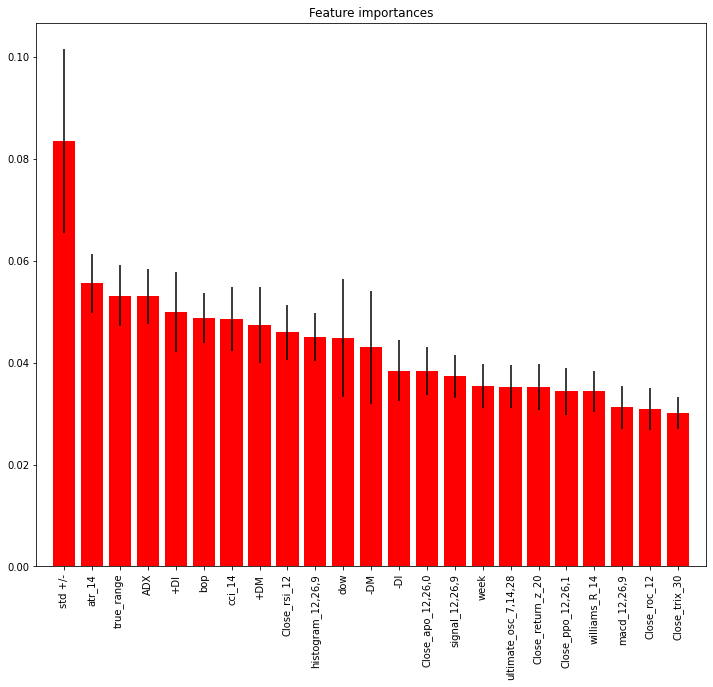

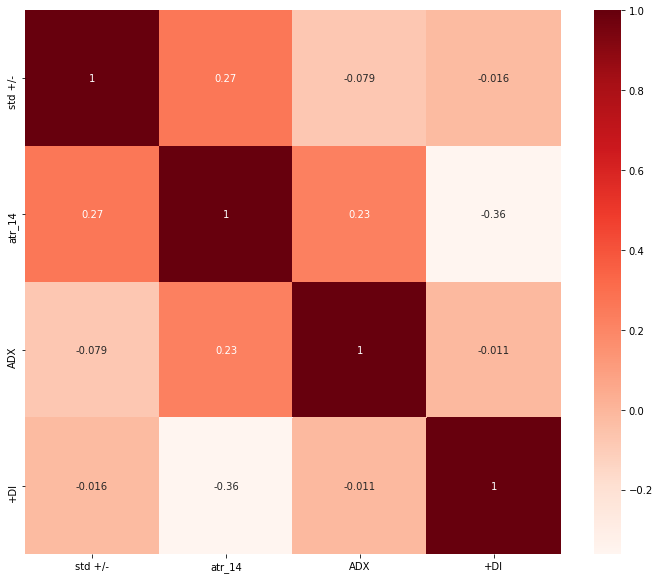

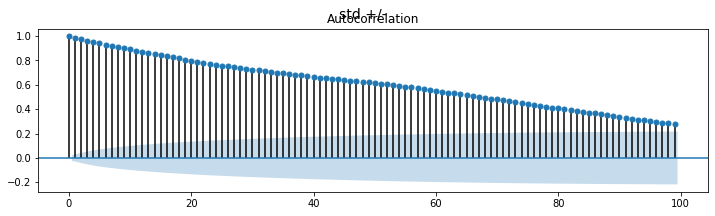

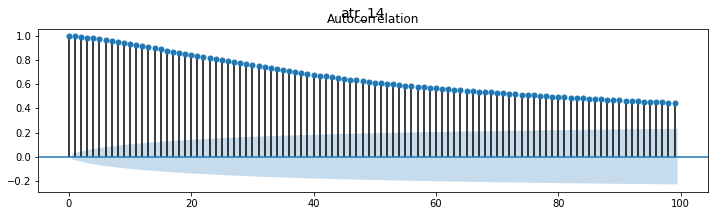

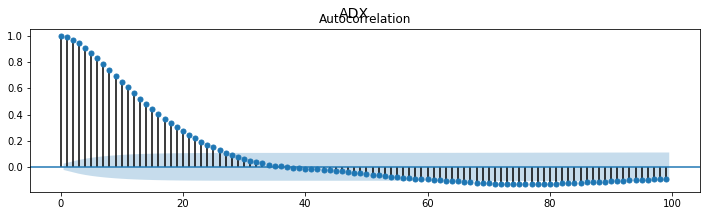

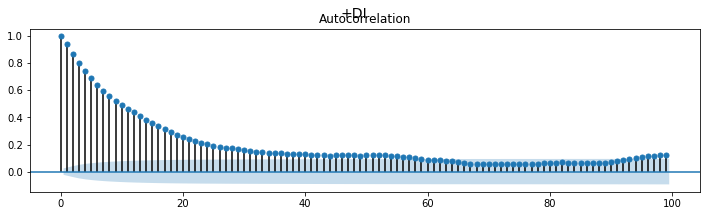

In [16]:
features, lags = df.model.feature_selection(fnl)

In [17]:
features

['std +/-', 'atr_14', 'true_range', 'ADX', '+DI']

Now Lets have a closer look at this features - we try to see distinct clusters.

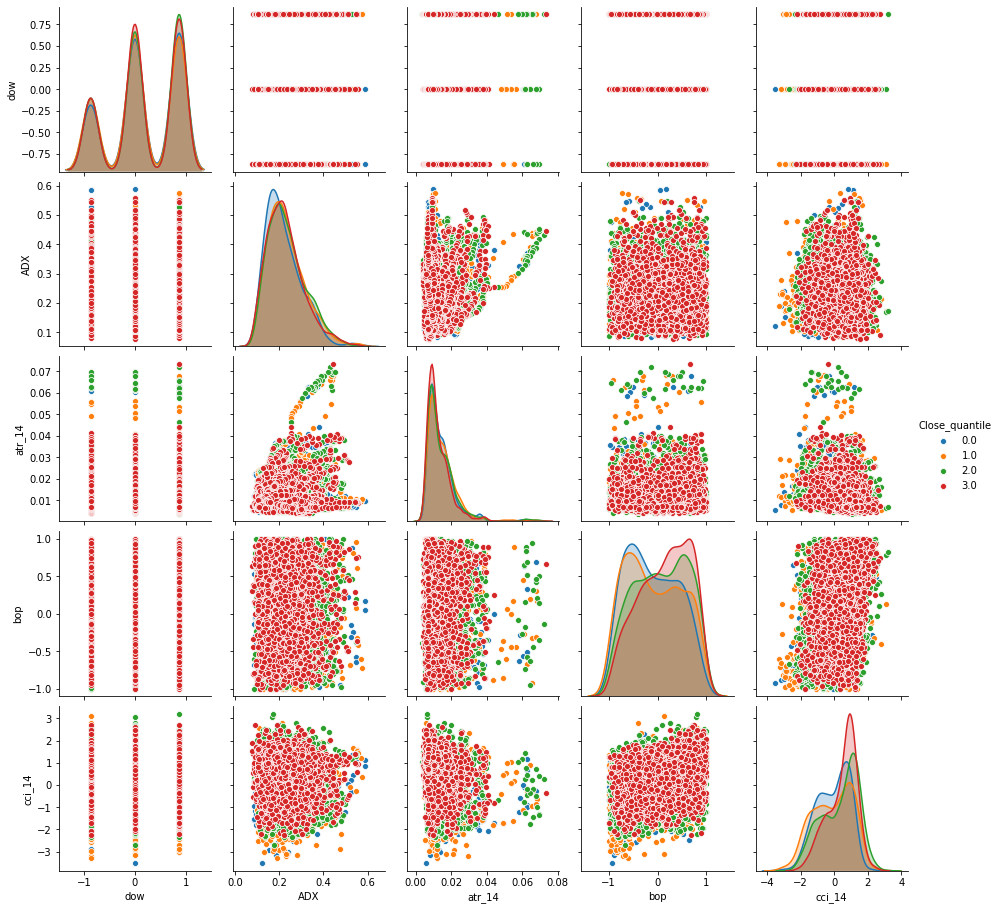

In [18]:
df.model.plot_features(
    FeaturesAndLabels(
        features=[
            lambda df: df["Close"].ta.sinusoidal_week_day(),
            lambda df: df.ta.adx()[["ADX"]], 
            lambda df: df.ta.atr(),
            lambda df: df.ta.bop(),
            lambda df: df.ta.cci(),
        ],
        labels=[
            lambda df: df["Close"].ta.future_bband_quantile(5, 5, stddev=2.0)

        ],
        targets=[
            lambda df: df["Close"].ta.bbands(5, stddev=2.0)[["lower", "upper"]]
        ]
    )
)

Ideally we should see that there is some pattern which can seperate the features per label (color). 

So now we can build up a model from the learnings we have made. To make it a little more interesting we could use crossvalidation i.e. a K-Folds algorithm.

In [19]:
from pandas_ml_utils.ml.data.splitting import RandomSplits
from pandas_ml_utils.ml.data.splitting.sampeling import KFoldBoostRareEvents, KEquallyWeightEvents
from pandas_ml_quant import pd, np, PostProcessedFeaturesAndLabels

fit = df.model.fit(
    SkModel(
        MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 50), random_state=42, alpha=2.0),
        PostProcessedFeaturesAndLabels(
            features=[
                lambda df: df["Close"].ta.sinusoidal_week_day(),
                lambda df: df.ta.adx()[["ADX"]],
                lambda df: df.ta.atr(),
                lambda df: df.ta.bop(),
                lambda df: df.ta.cci(),
            ],
            feature_post_processor=[lambda df: df.ta.rnn(lags)],
            labels=[
                lambda df: df["Close"].ta.future_bband_quantile(5, 5, stddev=2.0).ta.one_hot_encode_discrete()
            ],
            targets=[
                lambda df: df["Close"].ta.bbands(5, stddev=2.0)[["lower", "mean", "upper"]]
            ]
        ),
        summary_provider=ClassificationSummary,
    ),
    RandomSplits(cross_validation=(1, KFoldBoostRareEvents(3).split))
)

fit

ERROR:pandas_ml_quant.model.post_processed_features_and_labels:This class is only here for backward compatibility of saved Models, use: `from pandas_ml_utils import PostProcessedFeaturesAndLabels` instead!!


This obviously is not the besst model but you got the Idea. Also not the quite large penalization term which is "engineered" by trail and error. However One could also use the Hyperparameter optimization possibility:

```python
fit = df.model.fit(
    SkModel(...),
    test_size=0.4,
    test_validate_split_seed=42,
    hyper_parameter_space={'alpha': hp.choice('alpha', [0.0001, 10]), 'max_iter': 50,
                           '__max_evals': 4, '__rstate': np.random.RandomState(42)}
```

The leading `__` is used as a prefix for parameters passed to [hyperopt](https://github.com/hyperopt/hyperopt). All other parameters are passed to the model, like `max_iter` or `alpha` are parameters passed to the sklearn MLClassifier.

Ok now if we want to know what the current prediction is for the next 5 days, we simply call

```python
df.model.predict(fit.model)[-1:]["prediction"]
# [[6.13729022e-06, 9.99999839e-01, 1.07792629e-08]]
```

Oh wait now we know that we expect the price to be in the middle band but what does this actually mean? Which values are the middle band?
This is where the target comes into play.

In [20]:
df.model.predict(fit.model, tail=3).map_prediction_to_target()

prediction
2020-03-13 (-inf, 238.28)      0.102373
           (238.28, 267.06)    0.035117
           (267.06, 295.83)    0.992920
           (295.83, inf)       0.000112
2020-03-16 (-inf, 221.25)      0.255780
           (221.25, 260.28)    0.335197
           (260.28, 299.31)    0.230904
           (299.31, inf)       0.001775
2020-03-17 (-inf, 224.62)      0.005217
           (224.62, 253.25)    0.142540
           (253.25, 281.89)    0.621380
           (281.89, inf)       0.027088

### Saving and Loading
Of corse we can save and load this model and just apply it to the data frame.

In [21]:
fit.model.save("/tmp/readme_model.dill")
model2 = Model.load("/tmp/readme_model.dill")
df.model.predict(model2, tail=1)

saved model to: /tmp/readme_model.dill


target                       \
                 lower     mean       upper   
Date                                          
2020-03-17  224.615775  253.254  281.892225   

                                                   prediction   feature  \
                                               Close_quantile  (0, dow)   
Date                                                                      
2020-03-17  [0.004976038086047817, 0.1516248954761334, 0.6...  0.866025   

                                                                 ...  \
           (1, dow)  (2, dow)      (3, dow)  (4, dow)  (5, dow)  ...   
Date                                                             ...   
2020-03-17      0.0 -0.866025  1.224647e-16  0.866025  0.866025  ...   

                                                                             \
           (97, cci_14) (95, cci_14) (96, cci_14) (92, cci_14) (98, cci_14)   
Date                                                                          
2020-03-17     0.937381     1.493002     1.507312     1.530051     0.829822   

                                                                              
           (93, cci_14) (94, cci_14) (91, cci_14) (99, cci_14) (100, cci_14)  
Date                                                                          
2020-03-17     0.987296     1.381767     1.616873     0.731723      0.831209  

[1 rows x 509 columns]